# Method 6 - Best Ideas High Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[best_ideas['focus_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

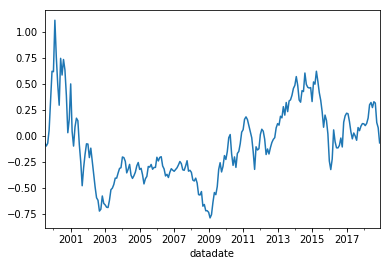

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.621135
2000-12-31   -0.283950
2001-12-31   -0.203700
2002-12-31   -0.619108
2003-12-31    0.973372
2004-12-31    0.071975
2005-12-31   -0.062661
2006-12-31   -0.038377
2007-12-31   -0.001922
2008-12-31   -0.579486
2009-12-31    1.879771
2010-12-31    0.277494
2011-12-31   -0.153819
2012-12-31    0.228652
2013-12-31    0.351517
2014-12-31    0.005491
2015-12-31   -0.303840
2016-12-31    0.170182
2017-12-31   -0.062553
2018-12-31   -0.165731
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     170.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.57e-67
Time:                        13:57:03   Log-Likelihood:                 312.34
No. Observations:                 234   AIC:                            -614.7
Df Residuals:                     229   BIC:                            -597.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.004      0.995      0.321      -0.004       0.013
mktrf          1.4154      0.120     11.787      0.000       1.179       1.652
me             0.8197      0.140      5.868      0.000       0.544       1.095
ia             0.0539      0.212      0.254      0.800      -0.364       0.472
roe           -1.5807      0.182     -8.699      0.000      -1.939      -1.223
==============================================================================
Omnibus:                      140.189   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1501.532
Skew:                           2.140   Prob(JB):                         0.00
Kurtosis:                      14.649   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     88.51
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.38e-45
Time:                        13:57:03   Log-Likelihood:                 312.34
No. Observations:                 234   AIC:                            -614.7
Df Residuals:                     229   BIC:                            -597.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.004      1.030      0.303      -0.004       0.013
mktrf          1.4154      0.229      6.178      0.000       0.966       1.864
me             0.8197      0.161      5.103      0.000       0.505       1.135
ia             0.0539      0.277      0.195      0.846      -0.488       0.596
roe           -1.5807      0.281     -5.625      0.000      -2.131      -1.030
==============================================================================
Omnibus:                      140.189   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1501.532
Skew:                           2.140   Prob(JB):                         0.00
Kurtosis:                      14.649   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     100.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.00e-49
Time:                        13:57:03   Log-Likelihood:                 312.34
No. Observations:                 234   AIC:                            -614.7
Df Residuals:                     229   BIC:                            -597.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.005      0.948      0.343      -0.005       0.013
mktrf          1.4154      0.230      6.156      0.000       0.965       1.866
me             0.8197      0.176      4.654      0.000       0.475       1.165
ia             0.0539      0.284      0.190      0.850      -0.503       0.611
roe           -1.5807      0.305     -5.189      0.000      -2.178      -0.984
==============================================================================
Omnibus:                      140.189   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1501.532
Skew:                           2.140   Prob(JB):                         0.00
Kurtosis:                      14.649   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     128.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.01e-64
Time:                        13:57:03   Log-Likelihood:                 307.26
No. Observations:                 234   AIC:                            -602.5
Df Residuals:                     228   BIC:                            -581.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.005      0.731      0.465      -0.006       0.012
mktrf          1.5703      0.123     12.743      0.000       1.327       1.813
smb            0.8414      0.163      5.175      0.000       0.521       1.162
hml            0.1616      0.192      0.843      0.400      -0.216       0.539
rmw           -1.4710      0.217     -6.786      0.000      -1.898      -1.044
cma            0.1716      0.276      0.623      0.534      -0.371       0.714
==============================================================================
Omnibus:                      127.464   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              936.996
Skew:                           2.035   Prob(JB):                    3.42e-204
Kurtosis:                      11.919   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     87.40
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.05e-51
Time:                        13:57:03   Log-Likelihood:                 307.26
No. Observations:                 234   AIC:                            -602.5
Df Residuals:                     228   BIC:                            -581.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.005      0.719      0.472      -0.006       0.012
mktrf          1.5703      0.150     10.450      0.000       1.276       1.865
smb            0.8414      0.179      4.708      0.000       0.491       1.192
hml            0.1616      0.319      0.507      0.612      -0.463       0.786
rmw           -1.4710      0.272     -5.411      0.000      -2.004      -0.938
cma            0.1716      0.364      0.472      0.637      -0.541       0.884
==============================================================================
Omnibus:                      127.464   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              936.996
Skew:                           2.035   Prob(JB):                    3.42e-204
Kurtosis:                      11.919   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     88.61
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.80e-51
Time:                        13:57:03   Log-Likelihood:                 307.26
No. Observations:                 234   AIC:                            -602.5
Df Residuals:                     228   BIC:                            -581.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.005      0.655      0.512      -0.007       0.013
mktrf          1.5703      0.141     11.111      0.000       1.293       1.847
smb            0.8414      0.179      4.713      0.000       0.491       1.191
hml            0.1616      0.266      0.606      0.544      -0.361       0.684
rmw           -1.4710      0.283     -5.189      0.000      -2.027      -0.915
cma            0.1716      0.334      0.514      0.607      -0.482       0.826
==============================================================================
Omnibus:                      127.464   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              936.996
Skew:                           2.035   Prob(JB):                    3.42e-204
Kurtosis:                      11.919   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     159.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.44e-65
Time:                        13:57:03   Log-Likelihood:                 306.55
No. Observations:                 234   AIC:                            -603.1
Df Residuals:                     229   BIC:                            -585.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.004     -0.131      0.896      -0.009       0.008
mktrf          1.6416      0.113     14.486      0.000       1.418       1.865
smb            1.5546      0.141     10.990      0.000       1.276       1.833
hml           -0.1323      0.141     -0.942      0.347      -0.409       0.145
umd           -0.5793      0.092     -6.283      0.000      -0.761      -0.398
==============================================================================
Omnibus:                      127.500   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1145.261
Skew:                           1.949   Prob(JB):                    2.04e-249
Kurtosis:                      13.112   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     89.91
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.01e-46
Time:                        13:57:03   Log-Likelihood:                 306.55
No. Observations:                 234   AIC:                            -603.1
Df Residuals:                     229   BIC:                            -585.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.004     -0.145      0.885      -0.008       0.007
mktrf          1.6416      0.183      8.960      0.000       1.283       2.001
smb            1.5546      0.142     10.917      0.000       1.275       1.834
hml           -0.1323      0.234     -0.565      0.572      -0.591       0.326
umd           -0.5793      0.134     -4.310      0.000      -0.843      -0.316
==============================================================================
Omnibus:                      127.500   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1145.261
Skew:                           1.949   Prob(JB):                    2.04e-249
Kurtosis:                      13.112   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     95.84
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.94e-48
Time:                        13:57:03   Log-Likelihood:                 306.55
No. Observations:                 234   AIC:                            -603.1
Df Residuals:                     229   BIC:                            -585.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.004     -0.137      0.891      -0.009       0.008
mktrf          1.6416      0.180      9.105      0.000       1.288       1.995
smb            1.5546      0.135     11.504      0.000       1.290       1.819
hml           -0.1323      0.223     -0.594      0.553      -0.569       0.304
umd           -0.5793      0.139     -4.176      0.000      -0.851      -0.307
==============================================================================
Omnibus:                      127.500   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1145.261
Skew:                           1.949   Prob(JB):                    2.04e-249
Kurtosis:                      13.112   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     90.03
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.67e-34
Time:                        13:57:03   Log-Likelihood:                 145.82
No. Observations:                 120   AIC:                            -281.6
Df Residuals:                     115   BIC:                            -267.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0098      0.007      1.401      0.164      -0.004       0.024
mktrf          1.3137      0.189      6.951      0.000       0.939       1.688
me             0.7291      0.187      3.906      0.000       0.359       1.099
ia            -0.3099      0.292     -1.060      0.291      -0.889       0.269
roe           -1.5207      0.259     -5.878      0.000      -2.033      -1.008
==============================================================================
Omnibus:                       75.171   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              529.337
Skew:                           2.015   Prob(JB):                    1.14e-115
Kurtosis:                      12.467   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     84.92
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.06e-33
Time:                        13:57:03   Log-Likelihood:                 145.82
No. Observations:                 120   AIC:                            -281.6
Df Residuals:                     115   BIC:                            -267.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0098      0.006      1.570      0.116      -0.002       0.022
mktrf          1.3137      0.359      3.660      0.000       0.610       2.017
me             0.7291      0.218      3.340      0.001       0.301       1.157
ia            -0.3099      0.361     -0.860      0.390      -1.017       0.397
roe           -1.5207      0.378     -4.028      0.000      -2.261      -0.781
==============================================================================
Omnibus:                       75.171   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              529.337
Skew:                           2.015   Prob(JB):                    1.14e-115
Kurtosis:                      12.467   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     107.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.12e-38
Time:                        13:57:03   Log-Likelihood:                 145.82
No. Observations:                 120   AIC:                            -281.6
Df Residuals:                     115   BIC:                            -267.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0098      0.007      1.493      0.135      -0.003       0.023
mktrf          1.3137      0.368      3.572      0.000       0.593       2.035
me             0.7291      0.235      3.097      0.002       0.268       1.190
ia            -0.3099      0.335     -0.926      0.354      -0.966       0.346
roe           -1.5207      0.430     -3.538      0.000      -2.363      -0.678
==============================================================================
Omnibus:                       75.171   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              529.337
Skew:                           2.015   Prob(JB):                    1.14e-115
Kurtosis:                      12.467   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     71.44
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.66e-33
Time:                        13:57:03   Log-Likelihood:                 145.84
No. Observations:                 120   AIC:                            -279.7
Df Residuals:                     114   BIC:                            -263.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0098      0.007      1.352      0.179      -0.005       0.024
mktrf          1.7020      0.200      8.504      0.000       1.305       2.098
smb            0.8476      0.227      3.739      0.000       0.399       1.297
hml           -0.3631      0.278     -1.307      0.194      -0.913       0.187
rmw           -1.0224      0.328     -3.122      0.002      -1.671      -0.374
cma            0.2254      0.359      0.628      0.531      -0.485       0.936
==============================================================================
Omnibus:                       73.682   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.540
Skew:                           2.096   Prob(JB):                     4.74e-87
Kurtosis:                      10.870   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     50.86
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.81e-27
Time:                        13:57:03   Log-Likelihood:                 145.84
No. Observations:                 120   AIC:                            -279.7
Df Residuals:                     114   BIC:                            -263.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0098      0.006      1.586      0.113      -0.002       0.022
mktrf          1.7020      0.270      6.297      0.000       1.172       2.232
smb            0.8476      0.249      3.410      0.001       0.360       1.335
hml           -0.3631      0.220     -1.649      0.099      -0.795       0.068
rmw           -1.0224      0.350     -2.923      0.003      -1.708      -0.337
cma            0.2254      0.384      0.587      0.557      -0.527       0.977
==============================================================================
Omnibus:                       73.682   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.540
Skew:                           2.096   Prob(JB):                     4.74e-87
Kurtosis:                      10.870   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     56.80
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.28e-29
Time:                        13:57:03   Log-Likelihood:                 145.84
No. Observations:                 120   AIC:                            -279.7
Df Residuals:                     114   BIC:                            -263.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0098      0.007      1.455      0.146      -0.003       0.023
mktrf          1.7020      0.234      7.261      0.000       1.243       2.161
smb            0.8476      0.235      3.609      0.000       0.387       1.308
hml           -0.3631      0.157     -2.319      0.020      -0.670      -0.056
rmw           -1.0224      0.368     -2.776      0.006      -1.744      -0.301
cma            0.2254      0.335      0.673      0.501      -0.431       0.882
==============================================================================
Omnibus:                       73.682   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              397.540
Skew:                           2.096   Prob(JB):                     4.74e-87
Kurtosis:                      10.870   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     101.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.44e-37
Time:                        13:57:03   Log-Likelihood:                 151.50
No. Observations:                 120   AIC:                            -293.0
Df Residuals:                     115   BIC:                            -279.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.007      0.914      0.363      -0.007       0.019
mktrf          1.6519      0.159     10.401      0.000       1.337       1.966
smb            1.4484      0.181      8.010      0.000       1.090       1.807
hml           -0.5239      0.181     -2.893      0.005      -0.883      -0.165
umd           -0.5355      0.112     -4.795      0.000      -0.757      -0.314
==============================================================================
Omnibus:                       75.715   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              551.202
Skew:                           2.018   Prob(JB):                    2.03e-120
Kurtosis:                      12.692   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     124.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.30e-41
Time:                        13:57:03   Log-Likelihood:                 151.50
No. Observations:                 120   AIC:                            -293.0
Df Residuals:                     115   BIC:                            -279.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.005      1.115      0.265      -0.005       0.017
mktrf          1.6519      0.256      6.447      0.000       1.150       2.154
smb            1.4484      0.162      8.965      0.000       1.132       1.765
hml           -0.5239      0.270     -1.942      0.052      -1.053       0.005
umd           -0.5355      0.148     -3.619      0.000      -0.825      -0.246
==============================================================================
Omnibus:                       75.715   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              551.202
Skew:                           2.018   Prob(JB):                    2.03e-120
Kurtosis:                      12.692   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     280.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.47e-58
Time:                        13:57:03   Log-Likelihood:                 151.50
No. Observations:                 120   AIC:                            -293.0
Df Residuals:                     115   BIC:                            -279.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.006      1.061      0.289      -0.005       0.017
mktrf          1.6519      0.255      6.478      0.000       1.152       2.152
smb            1.4484      0.144     10.042      0.000       1.166       1.731
hml           -0.5239      0.236     -2.222      0.026      -0.986      -0.062
umd           -0.5355      0.158     -3.379      0.001      -0.846      -0.225
==============================================================================
Omnibus:                       75.715   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              551.202
Skew:                           2.018   Prob(JB):                    2.03e-120
Kurtosis:                      12.692   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     85.58
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.92e-33
Time:                        13:57:03   Log-Likelihood:                 177.70
No. Observations:                 114   AIC:                            -345.4
Df Residuals:                     109   BIC:                            -331.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.005     -0.170      0.865      -0.011       0.009
mktrf          1.5205      0.153      9.934      0.000       1.217       1.824
me             0.9140      0.236      3.867      0.000       0.446       1.382
ia             0.6790      0.328      2.071      0.041       0.029       1.329
roe           -1.8291      0.288     -6.350      0.000      -2.400      -1.258
==============================================================================
Omnibus:                       30.344   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.921
Skew:                           1.033   Prob(JB):                     1.78e-15
Kurtosis:                       6.167   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     78.61
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.14e-31
Time:                        13:57:03   Log-Likelihood:                 177.70
No. Observations:                 114   AIC:                            -345.4
Df Residuals:                     109   BIC:                            -331.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.004     -0.240      0.810      -0.008       0.006
mktrf          1.5205      0.184      8.285      0.000       1.161       1.880
me             0.9140      0.334      2.733      0.006       0.259       1.569
ia             0.6790      0.359      1.892      0.059      -0.024       1.382
roe           -1.8291      0.537     -3.405      0.001      -2.882      -0.776
==============================================================================
Omnibus:                       30.344   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.921
Skew:                           1.033   Prob(JB):                     1.78e-15
Kurtosis:                       6.167   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     89.17
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.82e-33
Time:                        13:57:03   Log-Likelihood:                 177.70
No. Observations:                 114   AIC:                            -345.4
Df Residuals:                     109   BIC:                            -331.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.003     -0.274      0.784      -0.007       0.005
mktrf          1.5205      0.170      8.946      0.000       1.187       1.854
me             0.9140      0.391      2.338      0.019       0.148       1.680
ia             0.6790      0.397      1.711      0.087      -0.099       1.457
roe           -1.8291      0.540     -3.389      0.001      -2.887      -0.771
==============================================================================
Omnibus:                       30.344   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.921
Skew:                           1.033   Prob(JB):                     1.78e-15
Kurtosis:                       6.167   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     67.12
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.51e-31
Time:                        13:57:03   Log-Likelihood:                 177.24
No. Observations:                 114   AIC:                            -342.5
Df Residuals:                     108   BIC:                            -326.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.005     -0.601      0.549      -0.014       0.007
mktrf          1.5591      0.147     10.588      0.000       1.267       1.851
smb            0.8098      0.239      3.388      0.001       0.336       1.284
hml            0.9029      0.305      2.962      0.004       0.299       1.507
rmw           -1.7355      0.373     -4.649      0.000      -2.475      -0.996
cma            0.0941      0.474      0.199      0.843      -0.845       1.033
==============================================================================
Omnibus:                       35.025   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.705
Skew:                           0.967   Prob(JB):                     1.53e-29
Kurtosis:                       7.919   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     89.70
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.97e-37
Time:                        13:57:03   Log-Likelihood:                 177.24
No. Observations:                 114   AIC:                            -342.5
Df Residuals:                     108   BIC:                            -326.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.005     -0.628      0.530      -0.013       0.007
mktrf          1.5591      0.137     11.377      0.000       1.290       1.828
smb            0.8098      0.296      2.733      0.006       0.229       1.390
hml            0.9029      0.254      3.559      0.000       0.406       1.400
rmw           -1.7355      0.477     -3.635      0.000      -2.671      -0.800
cma            0.0941      0.379      0.249      0.804      -0.648       0.836
==============================================================================
Omnibus:                       35.025   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.705
Skew:                           0.967   Prob(JB):                     1.53e-29
Kurtosis:                       7.919   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     105.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.00e-40
Time:                        13:57:03   Log-Likelihood:                 177.24
No. Observations:                 114   AIC:                            -342.5
Df Residuals:                     108   BIC:                            -326.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.005     -0.651      0.515      -0.013       0.006
mktrf          1.5591      0.142     10.951      0.000       1.280       1.838
smb            0.8098      0.341      2.374      0.018       0.141       1.478
hml            0.9029      0.221      4.085      0.000       0.470       1.336
rmw           -1.7355      0.452     -3.836      0.000      -2.622      -0.849
cma            0.0941      0.396      0.238      0.812      -0.681       0.870
==============================================================================
Omnibus:                       35.025   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.705
Skew:                           0.967   Prob(JB):                     1.53e-29
Kurtosis:                       7.919   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     72.69
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.09e-30
Time:                        13:57:03   Log-Likelihood:                 170.78
No. Observations:                 114   AIC:                            -331.6
Df Residuals:                     109   BIC:                            -317.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045      0.005     -0.811      0.419      -0.015       0.006
mktrf          1.6142      0.154     10.474      0.000       1.309       1.920
smb            1.2148      0.240      5.055      0.000       0.739       1.691
hml            0.9513      0.248      3.844      0.000       0.461       1.442
umd           -0.5455      0.187     -2.922      0.004      -0.916      -0.175
==============================================================================
Omnibus:                       39.354   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.050
Skew:                           1.038   Prob(JB):                     1.32e-39
Kurtosis:                       8.778   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     122.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.35e-39
Time:                        13:57:03   Log-Likelihood:                 170.78
No. Observations:                 114   AIC:                            -331.6
Df Residuals:                     109   BIC:                            -317.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045      0.005     -0.930      0.352      -0.014       0.005
mktrf          1.6142      0.158     10.241      0.000       1.305       1.923
smb            1.2148      0.278      4.364      0.000       0.669       1.760
hml            0.9513      0.273      3.482      0.000       0.416       1.487
umd           -0.5455      0.137     -3.973      0.000      -0.815      -0.276
==============================================================================
Omnibus:                       39.354   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.050
Skew:                           1.038   Prob(JB):                     1.32e-39
Kurtosis:                       8.778   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     148.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.48e-43
Time:                        13:57:03   Log-Likelihood:                 170.78
No. Observations:                 114   AIC:                            -331.6
Df Residuals:                     109   BIC:                            -317.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045      0.005     -0.940      0.347      -0.014       0.005
mktrf          1.6142      0.164      9.867      0.000       1.294       1.935
smb            1.2148      0.281      4.327      0.000       0.665       1.765
hml            0.9513      0.272      3.495      0.000       0.418       1.485
umd           -0.5455      0.114     -4.796      0.000      -0.768      -0.323
==============================================================================
Omnibus:                       39.354   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.050
Skew:                           1.038   Prob(JB):                     1.32e-39
Kurtosis:                       8.778   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""